In [4]:


from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import os
import cv2
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision import models
!pip install scikit-learn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
!pip install seaborn
!pip install timm
import timm
from timm.loss import LabelSmoothingCrossEntropy
import torch.nn as nn
import torch.optim as optim
import copy
from tqdm import tqdm
import time

In [12]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

def load_data(directory, input_shape):
    x = []
    y = []
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            for file_name in os.listdir(class_dir):
                file_path = os.path.join(class_dir, file_name)
                image = cv2.imread(file_path)
                image = cv2.resize(image, (input_shape[1], input_shape[0]))
                x.append(image)
                y.append(class_name)
    x = np.array(x)
    y = np.array(y)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    return x, y_encoded, label_encoder.classes_

input_shape = (512, 512, 3)
train_dir = '/content/drive/MyDrive/Chiro10/train_512'
test_dir = '/content/drive/MyDrive/Chiro10/test_512'
val_dir = '/content/drive/MyDrive/Chiro10/val_512'

x_train, y_train, classes = load_data(train_dir, input_shape)
x_test, y_test, _ = load_data(test_dir, input_shape)
x_val, y_val, _ = load_data(val_dir, input_shape)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")

transform = T.Compose([
    T.ToPILImage(),
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

train_dataset = CustomDataset(x_train, y_train, transform=transform)
test_dataset = CustomDataset(x_test, y_test, transform=transform)
val_dataset = CustomDataset(x_val, y_val, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

dataloaders = {
    "train": train_dataloader,
    "val": val_dataloader
}

dataset_sizes = {
    "train": len(train_dataset),
    "val": len(val_dataset)
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=len(classes))
model = model.to(device)

criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-"*10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc =  running_corrects.double() / dataset_sizes[phase]

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model

def evaluate_model(model, criterion, dataloader):
    model.eval()  # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    print('{} Loss: {:.4f} Acc: {:.4f}'.format('test', epoch_loss, epoch_acc))


def evaluate_model(model, criterion, dataloader):
    model.eval()  # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    print('{} Loss: {:.4f} Acc: {:.4f}'.format('test', epoch_loss, epoch_acc))



model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=40)
evaluate_model(model, criterion, test_dataloader)
torch.save(model.state_dict(), '/content/drive/MyDrive/Chiro10/efficientnet_b0_chiro10.pth')


x_train shape: (923, 512, 512, 3) - y_train shape: (923,)
x_test shape: (554, 512, 512, 3) - y_test shape: (554,)
x_val shape: (369, 512, 512, 3) - y_val shape: (369,)
Epoch 0/39
----------


100%|██████████| 8/8 [00:08<00:00,  1.12s/it]


train Loss: 1.6361 Acc: 0.6826


100%|██████████| 12/12 [00:01<00:00,  6.64it/s]


val Loss: 1.5187 Acc: 0.6016

Epoch 1/39
----------


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


train Loss: 0.8224 Acc: 0.9426


100%|██████████| 12/12 [00:01<00:00,  6.00it/s]


val Loss: 1.1119 Acc: 0.7724

Epoch 2/39
----------


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


train Loss: 0.6848 Acc: 0.9816


100%|██████████| 12/12 [00:02<00:00,  4.87it/s]


val Loss: 0.8045 Acc: 0.9268

Epoch 3/39
----------


100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


train Loss: 0.6083 Acc: 0.9989


100%|██████████| 12/12 [00:01<00:00,  6.95it/s]


val Loss: 0.7852 Acc: 0.9133

Epoch 4/39
----------


100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


train Loss: 0.5748 Acc: 1.0000


100%|██████████| 12/12 [00:02<00:00,  4.72it/s]


val Loss: 0.6548 Acc: 0.9675

Epoch 5/39
----------


100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


train Loss: 0.5566 Acc: 0.9989


100%|██████████| 12/12 [00:01<00:00,  6.91it/s]


val Loss: 0.6352 Acc: 0.9621

Epoch 6/39
----------


100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


train Loss: 0.5381 Acc: 1.0000


100%|██████████| 12/12 [00:01<00:00,  6.82it/s]


val Loss: 0.6203 Acc: 0.9648

Epoch 7/39
----------


100%|██████████| 8/8 [00:09<00:00,  1.14s/it]


train Loss: 0.5339 Acc: 1.0000


100%|██████████| 12/12 [00:01<00:00,  6.31it/s]


val Loss: 0.6078 Acc: 0.9675

Epoch 8/39
----------


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


train Loss: 0.5222 Acc: 1.0000


100%|██████████| 12/12 [00:01<00:00,  6.04it/s]


val Loss: 0.6033 Acc: 0.9702

Epoch 9/39
----------


100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


train Loss: 0.5214 Acc: 1.0000


100%|██████████| 12/12 [00:01<00:00,  6.75it/s]


val Loss: 0.5903 Acc: 0.9729

Epoch 10/39
----------


100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


train Loss: 0.5179 Acc: 1.0000


100%|██████████| 12/12 [00:01<00:00,  6.83it/s]


val Loss: 0.5944 Acc: 0.9729

Epoch 11/39
----------


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


train Loss: 0.5174 Acc: 1.0000


100%|██████████| 12/12 [00:02<00:00,  4.93it/s]


val Loss: 0.5858 Acc: 0.9837

Epoch 12/39
----------


100%|██████████| 8/8 [00:07<00:00,  1.03it/s]


train Loss: 0.5165 Acc: 1.0000


100%|██████████| 12/12 [00:01<00:00,  6.84it/s]


val Loss: 0.5888 Acc: 0.9810

Epoch 13/39
----------


100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


train Loss: 0.5156 Acc: 1.0000


100%|██████████| 12/12 [00:01<00:00,  6.85it/s]


val Loss: 0.5917 Acc: 0.9783

Epoch 14/39
----------


100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


train Loss: 0.5217 Acc: 1.0000


100%|██████████| 12/12 [00:02<00:00,  4.67it/s]


val Loss: 0.5986 Acc: 0.9837

Epoch 15/39
----------


100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


train Loss: 0.5168 Acc: 1.0000


100%|██████████| 12/12 [00:01<00:00,  6.83it/s]


val Loss: 0.5982 Acc: 0.9783

Epoch 16/39
----------


100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


train Loss: 0.5138 Acc: 1.0000


100%|██████████| 12/12 [00:01<00:00,  6.90it/s]


val Loss: 0.5840 Acc: 0.9810

Epoch 17/39
----------


100%|██████████| 8/8 [00:07<00:00,  1.02it/s]


train Loss: 0.5115 Acc: 1.0000


100%|██████████| 12/12 [00:02<00:00,  5.70it/s]


val Loss: 0.5846 Acc: 0.9783

Epoch 18/39
----------


100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


train Loss: 0.5129 Acc: 1.0000


100%|██████████| 12/12 [00:01<00:00,  6.85it/s]


val Loss: 0.5862 Acc: 0.9837

Epoch 19/39
----------


100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


train Loss: 0.5217 Acc: 1.0000


100%|██████████| 12/12 [00:01<00:00,  6.89it/s]


val Loss: 0.5979 Acc: 0.9837

Epoch 20/39
----------


100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


train Loss: 0.5277 Acc: 1.0000


100%|██████████| 12/12 [00:01<00:00,  6.77it/s]


val Loss: 0.6065 Acc: 0.9837

Epoch 21/39
----------


100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


train Loss: 0.5245 Acc: 1.0000


100%|██████████| 12/12 [00:02<00:00,  5.41it/s]


val Loss: 0.6045 Acc: 0.9810

Epoch 22/39
----------


100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


train Loss: 0.5226 Acc: 1.0000


100%|██████████| 12/12 [00:01<00:00,  7.04it/s]


val Loss: 0.5901 Acc: 0.9864

Epoch 23/39
----------


100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


train Loss: 0.5154 Acc: 1.0000


100%|██████████| 12/12 [00:01<00:00,  7.00it/s]


val Loss: 0.5799 Acc: 0.9892

Epoch 24/39
----------


100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


train Loss: 0.5144 Acc: 1.0000


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


val Loss: 0.5838 Acc: 0.9837

Epoch 25/39
----------


100%|██████████| 8/8 [00:07<00:00,  1.04it/s]


train Loss: 0.5210 Acc: 1.0000


100%|██████████| 12/12 [00:01<00:00,  6.89it/s]


val Loss: 0.5907 Acc: 0.9837

Epoch 26/39
----------


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


train Loss: 0.5162 Acc: 1.0000


100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


val Loss: 0.5936 Acc: 0.9837

Epoch 27/39
----------


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


train Loss: 0.5146 Acc: 1.0000


100%|██████████| 12/12 [00:01<00:00,  6.77it/s]


val Loss: 0.5768 Acc: 0.9864

Epoch 28/39
----------


100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


train Loss: 0.5133 Acc: 1.0000


100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


val Loss: 0.5770 Acc: 0.9837

Epoch 29/39
----------


100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


train Loss: 0.5178 Acc: 1.0000


100%|██████████| 12/12 [00:01<00:00,  7.05it/s]


val Loss: 0.5890 Acc: 0.9810

Epoch 30/39
----------


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


train Loss: 0.5113 Acc: 1.0000


100%|██████████| 12/12 [00:01<00:00,  6.89it/s]


val Loss: 0.5823 Acc: 0.9864

Epoch 31/39
----------


100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


train Loss: 0.5099 Acc: 1.0000


100%|██████████| 12/12 [00:02<00:00,  4.78it/s]


val Loss: 0.5723 Acc: 0.9864

Epoch 32/39
----------


100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


train Loss: 0.5149 Acc: 1.0000


100%|██████████| 12/12 [00:01<00:00,  6.79it/s]


val Loss: 0.5837 Acc: 0.9837

Epoch 33/39
----------


100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


train Loss: 0.5123 Acc: 1.0000


100%|██████████| 12/12 [00:01<00:00,  6.75it/s]


val Loss: 0.5688 Acc: 0.9864

Epoch 34/39
----------


100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


train Loss: 0.5101 Acc: 1.0000


100%|██████████| 12/12 [00:02<00:00,  5.77it/s]


val Loss: 0.5747 Acc: 0.9837

Epoch 35/39
----------


100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


train Loss: 0.5069 Acc: 1.0000


100%|██████████| 12/12 [00:01<00:00,  6.62it/s]


val Loss: 0.5731 Acc: 0.9864

Epoch 36/39
----------


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


train Loss: 0.5065 Acc: 1.0000


100%|██████████| 12/12 [00:01<00:00,  6.78it/s]


val Loss: 0.5674 Acc: 0.9864

Epoch 37/39
----------


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


train Loss: 0.5057 Acc: 1.0000


100%|██████████| 12/12 [00:01<00:00,  6.96it/s]


val Loss: 0.5705 Acc: 0.9864

Epoch 38/39
----------


100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


train Loss: 0.5061 Acc: 1.0000


100%|██████████| 12/12 [00:02<00:00,  4.94it/s]


val Loss: 0.5690 Acc: 0.9837

Epoch 39/39
----------


100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


train Loss: 0.5046 Acc: 1.0000


100%|██████████| 12/12 [00:01<00:00,  6.96it/s]


val Loss: 0.5724 Acc: 0.9837

Training complete in 6m 36s
Best val Acc: 0.989160
test Loss: 0.5771 Acc: 0.9765


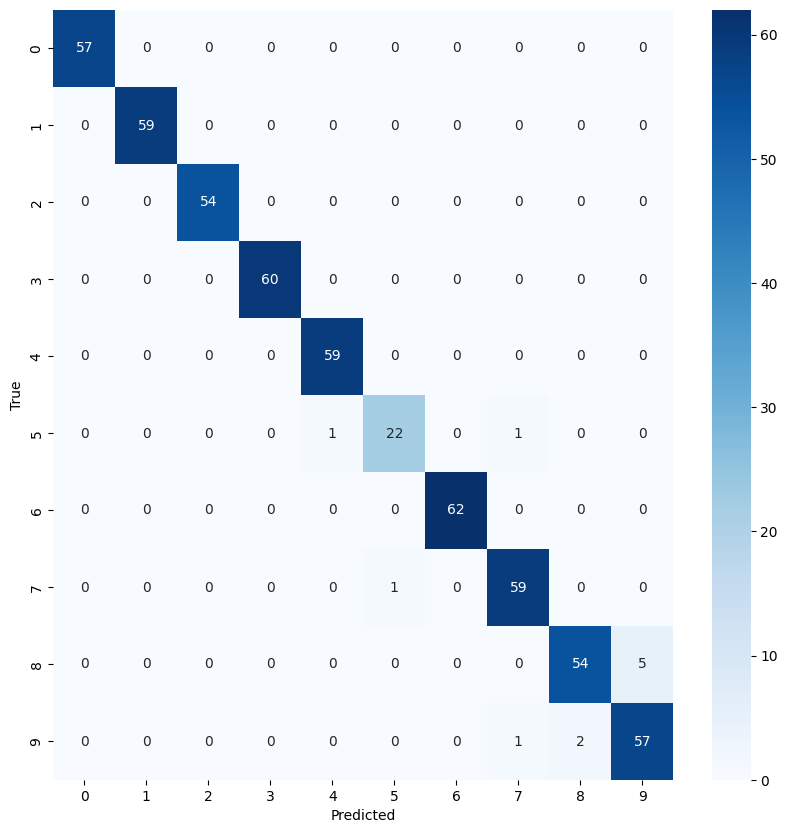

In [11]:
def plot_confusion_matrix(model, dataloader):
    model.eval()
    true_labels = []
    pred_labels = []

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(model, test_dataloader)